## Send를 활용한 RAG Multi-Query Generator 실습

목표
- Send 기능을 활용하여 동적 라우팅으로 멀티 쿼리를 생성하는 RAG 시스템을 구축합니다.
- 사용자의 복잡한 질문을 분해(decomposition)하여 sub-query를 생성하고 조합합니다.
- 건설 회사 내부 문서 검색 시스템을 위한 쿼리 생성기를 구현합니다.

요구사항
- 사용자의 질문을 분석하여 여러 개의 sub-query로 분해합니다.
- Send를 사용하여 각 sub-query를 동적으로 생성합니다.
- 생성된 sub-query들을 조합하여 최소 5개의 검색 쿼리를 생성합니다.
- Multi-hop 질문(여러 단계의 추론이 필요한 질문)을 처리할 수 있어야 합니다.

시나리오
- 건설 회사의 RAG 기반 사내 문서 검색 챗봇
- 프로젝트 관리, 안전 규정, 계약서, 기술 사양서 등의 문서를 검색
- 복잡한 질문을 여러 관점에서 검색하여 정확도를 높임

In [1]:
from dotenv import load_dotenv
from langchain_teddynote import logging

load_dotenv(override=True)

# 프로젝트 이름
logging.langsmith("LangGraph-Exercises")

LangSmith 추적을 시작합니다.
[프로젝트명]
LangGraph-Exercises


In [2]:
# 준비 코드
from typing import Annotated, List, Dict
from typing_extensions import TypedDict

from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages, AnyMessage
from langgraph.types import Send

### 1. State 정의 및 모델 설정

- MultiQueryState를 정의하세요. original_question, sub_queries, combined_queries, decomposed_aspects 필드가 필요합니다.
- SubQueryState를 정의하세요. aspect, query_number 필드가 필요합니다.
- ChatOpenAI 모델(gpt-4.1, temperature=0.7)을 생성하세요.

In [ ]:
# 실습 코드
# TODO: MultiQueryState를 정의하세요.
class MultiQueryState(TypedDict):
    original_question: # 코드 입력: str 타입
    sub_queries: # 코드 입력: List[str] 타입 with add reducer
    combined_queries: # 코드 입력: List[str] 타입
    decomposed_aspects: # 코드 입력: List[str] 타입

# TODO: SubQueryState를 정의하세요.
class SubQueryState(TypedDict):
    aspect: # 코드 입력: str 타입
    query_number: # 코드 입력: int 타입

# TODO: LLM 모델을 정의하세요.
llm = # 코드 입력

In [ ]:
# 정답 코드
# TODO: MultiQueryState를 정의하세요.
from operator import add


class MultiQueryState(TypedDict):
    original_question: str
    sub_queries: Annotated[List[str], add]  # 리스트를 누적
    combined_queries: List[str]
    decomposed_aspects: List[str]


# TODO: SubQueryState를 정의하세요.
class SubQueryState(TypedDict):
    aspect: str
    query_number: int


# TODO: LLM 모델을 정의하세요.
llm = ChatOpenAI(model="gpt-4.1", temperature=0.7)

### 2. 질문 분해 노드 구현

- 사용자의 원본 질문을 여러 관점(aspects)으로 분해하는 노드를 구현하세요.
- 건설 프로젝트 관련 질문을 기술적, 안전, 계약적, 일정 관점으로 분해합니다.
- LLM을 사용하여 질문을 분석하고 3-4개의 관점을 추출하세요.

In [ ]:
# 실습 코드
# TODO: 질문을 분해하는 노드를 구현하세요.

def decompose_question(state: MultiQueryState) -> Dict:
    """원본 질문을 여러 관점으로 분해합니다."""
    
    system_prompt = # 코드 입력: 건설 프로젝트 질문 분해를 위한 시스템 프롬프트
    
    user_prompt = # 코드 입력: 사용자 질문을 포함한 프롬프트
    
    # LLM으로 질문 분해
    messages = # 코드 입력: SystemMessage와 HumanMessage 리스트
    response = # 코드 입력: LLM 호출
    
    # 응답에서 관점 추출 (간단히 줄바꿈으로 구분)
    aspects = # 코드 입력: response.content를 파싱하여 리스트로 변환
    
    print(f"\n🔍 질문 분해 완료: {len(aspects)}개 관점")
    for i, aspect in enumerate(aspects, 1):
        print(f"  {i}. {aspect}")
    
    return {"decomposed_aspects": aspects}

In [ ]:
# 정답 코드
# TODO: 질문을 분해하는 노드를 구현하세요.


def decompose_question(state: MultiQueryState) -> Dict:
    """원본 질문을 여러 관점으로 분해합니다."""

    system_prompt = """당신은 건설 프로젝트 문서 검색 전문가입니다.
    주어진 질문을 다음 관점에서 분석하여 3-4개의 세부 검색 관점으로 분해하세요:
    1. 기술적 사양 관점
    2. 안전 및 규정 관점
    3. 계약 및 법적 관점
    4. 일정 및 비용 관점
    
    각 관점은 한 줄로 작성하고, 구체적이고 검색 가능한 형태로 작성하세요."""

    user_prompt = f"다음 질문을 분해하세요: {state['original_question']}"

    # LLM으로 질문 분해
    messages = [SystemMessage(content=system_prompt), HumanMessage(content=user_prompt)]
    response = llm.invoke(messages)

    # 응답에서 관점 추출 (간단히 줄바꿈으로 구분)
    aspects = [
        aspect.strip()
        for aspect in response.content.split("\n")
        if aspect.strip() and not aspect.strip().startswith("#")
    ]

    print(f"\n🔍 질문 분해 완료: {len(aspects)}개 관점")
    for i, aspect in enumerate(aspects, 1):
        print(f"  {i}. {aspect}")

    return {"decomposed_aspects": aspects}

### 3. Sub-query 생성 노드 구현

- 각 관점(aspect)에 대해 구체적인 검색 쿼리를 생성하는 노드를 구현하세요.
- SubQueryState를 입력으로 받아 sub_queries를 업데이트합니다.
- 각 관점당 2-3개의 다양한 쿼리를 생성하세요.

In [ ]:
# 실습 코드
# TODO: Sub-query를 생성하는 노드를 구현하세요.

def generate_subquery(state: SubQueryState) -> Dict:
    """특정 관점에 대한 sub-query를 생성합니다."""
    
    system_prompt = # 코드 입력: 쿼리 생성을 위한 시스템 프롬프트
    
    user_prompt = # 코드 입력: aspect를 기반으로 쿼리 생성 요청
    
    # LLM으로 쿼리 생성
    messages = # 코드 입력
    response = # 코드 입력
    
    # 생성된 쿼리들
    queries = # 코드 입력: response를 파싱하여 리스트로 변환
    
    print(f"  ✅ Query #{state['query_number']}: {queries[0][:50]}...")
    
    return {"sub_queries": queries}

In [ ]:
# 정답 코드
# TODO: Sub-query를 생성하는 노드를 구현하세요.


def generate_subquery(state: SubQueryState) -> Dict:
    """특정 관점에 대한 sub-query를 생성합니다."""

    system_prompt = """당신은 RAG 시스템을 위한 검색 쿼리 생성 전문가입니다.
    주어진 관점에 대해 2-3개의 구체적이고 다양한 검색 쿼리를 생성하세요.
    각 쿼리는 다른 각도에서 정보를 찾을 수 있도록 작성하세요.
    쿼리는 한국어로 작성하고, 각 쿼리는 새로운 줄로 구분하세요."""

    user_prompt = f"다음 관점에 대한 검색 쿼리를 생성하세요: {state['aspect']}"

    # LLM으로 쿼리 생성
    messages = [SystemMessage(content=system_prompt), HumanMessage(content=user_prompt)]
    response = llm.invoke(messages)

    # 생성된 쿼리들
    queries = [
        q.strip()
        for q in response.content.split("\n")
        if q.strip() and not q.strip().startswith("#")
    ]

    print(f"  ✅ Query #{state['query_number']}: {queries[0][:50]}...")

    return {"sub_queries": queries}

### 4. Query 조합 노드 구현

- 생성된 sub-query들을 조합하여 최종 검색 쿼리를 만드는 노드를 구현하세요.
- 서로 다른 관점의 쿼리들을 조합하여 multi-hop 쿼리를 생성합니다.
- 최소 5개 이상의 최종 쿼리를 생성하세요.

In [ ]:
# 실습 코드
# TODO: Query들을 조합하는 노드를 구현하세요.

def combine_queries(state: MultiQueryState) -> Dict:
    """Sub-query들을 조합하여 최종 검색 쿼리를 생성합니다."""
    
    sub_queries = state.get("sub_queries", [])
    original_question = state.get("original_question", "")
    
    combined = []
    
    # 1. 원본 질문 추가
    combined.append(# 코드 입력: 원본 질문)
    
    # 2. 모든 sub-query 추가
    combined.extend(# 코드 입력: sub_queries)
    
    # 3. 쿼리 조합 (2개씩 AND 조합)
    if len(sub_queries) >= 2:
        for i in range(min(3, len(sub_queries)-1)):
            combined_query = # 코드 입력: 두 쿼리를 AND로 조합
            combined.append(combined_query)
    
    # 중복 제거 및 최소 5개 보장
    combined = # 코드 입력: 중복 제거 로직
    
    print(f"\n🎯 최종 쿼리 생성 완료: {len(combined)}개")
    
    return {"combined_queries": combined}

In [ ]:
# 정답 코드
# TODO: Query들을 조합하는 노드를 구현하세요.


def combine_queries(state: MultiQueryState) -> Dict:
    """Sub-query들을 조합하여 최종 검색 쿼리를 생성합니다."""

    sub_queries = state.get("sub_queries", [])
    original_question = state.get("original_question", "")

    combined = []

    # 1. 원본 질문 추가
    combined.append(original_question)

    # 2. 모든 sub-query 추가
    combined.extend(sub_queries)

    # 3. 쿼리 조합 (2개씩 AND 조합)
    if len(sub_queries) >= 2:
        for i in range(min(3, len(sub_queries) - 1)):
            combined_query = f"{sub_queries[i]} AND {sub_queries[i+1]}"
            combined.append(combined_query)

    # 중복 제거 및 최소 5개 보장
    combined = list(dict.fromkeys(combined))  # 순서 유지하며 중복 제거

    # 5개 미만이면 변형 쿼리 추가
    while len(combined) < 5 and sub_queries:
        combined.append(f"관련 문서: {sub_queries[len(combined) % len(sub_queries)]}")

    print(f"\n🎯 최종 쿼리 생성 완료: {len(combined)}개")

    return {"combined_queries": combined[:10]}  # 최대 10개로 제한

### 5. Send를 활용한 동적 라우팅 구현

- decompose_question 노드 후 Send를 사용하여 동적으로 sub-query 생성을 라우팅하세요.
- 각 aspect에 대해 별도의 generate_subquery 노드를 병렬로 실행합니다.
- Send 리스트를 반환하는 라우팅 함수를 구현하세요.

In [ ]:
# 실습 코드
# TODO: Send를 사용한 동적 라우팅 함수를 구현하세요.

def route_to_subquery_generation(state: MultiQueryState) -> List[Send]:
    """각 aspect에 대해 Send로 sub-query 생성을 라우팅합니다."""
    
    aspects = state.get("decomposed_aspects", [])
    sends = []
    
    print(f"\n📤 {len(aspects)}개의 sub-query 생성 작업을 시작합니다...")
    
    for i, aspect in enumerate(aspects, 1):
        # 각 aspect에 대해 Send 객체 생성
        send_obj = # 코드 입력: Send 객체 생성 ("generate_subquery" 노드로, SubQueryState 전달)
        sends.append(send_obj)
    
    return sends

# TODO: 그래프 구성
builder = # 코드 입력: StateGraph 생성

# 노드 추가
builder.# 코드 입력: decompose_question 노드 추가
builder.# 코드 입력: generate_subquery 노드 추가
builder.# 코드 입력: combine_queries 노드 추가

# 엣지 추가
builder.# 코드 입력: START → decompose_question
builder.# 코드 입력: decompose_question → conditional_edges (Send 사용)
builder.# 코드 입력: generate_subquery → combine_queries
builder.# 코드 입력: combine_queries → END

# 그래프 컴파일
app = # 코드 입력

In [ ]:
# 정답 코드
# TODO: Send를 사용한 동적 라우팅 함수를 구현하세요.


def route_to_subquery_generation(state: MultiQueryState) -> List[Send]:
    """각 aspect에 대해 Send로 sub-query 생성을 라우팅합니다."""

    aspects = state.get("decomposed_aspects", [])
    sends = []

    print(f"\n📤 {len(aspects)}개의 sub-query 생성 작업을 시작합니다...")

    for i, aspect in enumerate(aspects, 1):
        # 각 aspect에 대해 Send 객체 생성
        send_obj = Send("generate_subquery", {"aspect": aspect, "query_number": i})
        sends.append(send_obj)

    return sends


# TODO: 그래프 구성
builder = StateGraph(MultiQueryState)

# 노드 추가
builder.add_node("decompose_question", decompose_question)
builder.add_node("generate_subquery", generate_subquery)
builder.add_node("combine_queries", combine_queries)

# 엣지 추가
builder.add_edge(START, "decompose_question")
builder.add_conditional_edges(
    "decompose_question", route_to_subquery_generation, ["generate_subquery"]
)
builder.add_edge("generate_subquery", "combine_queries")
builder.add_edge("combine_queries", END)

# 그래프 컴파일
app = builder.compile()

### 6. 그래프 시각화 및 실행

- 컴파일된 그래프를 시각화하세요.
- 건설 프로젝트 관련 Multi-hop 질문 3개로 테스트하세요.
- 생성된 쿼리들을 확인하고 품질을 평가하세요.

In [ ]:
# 실습 코드
# TODO: 그래프를 시각화하세요.
from langchain_teddynote.graphs import visualize_graph

# 코드 입력: 그래프 시각화

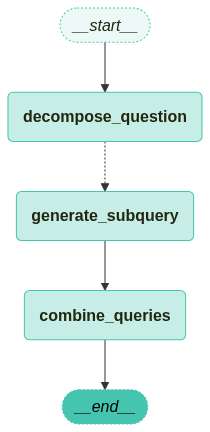

In [8]:
# 정답 코드
# TODO: 그래프를 시각화하세요.
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)

In [ ]:
# 실습 코드
# TODO: Multi-hop 질문으로 테스트하세요.

# 건설 프로젝트 관련 Multi-hop 질문 예제
test_questions = [
    "서울 강남 A타워 프로젝트에서 지하 3층 콘크리트 타설 시 안전 규정과 품질 기준을 모두 만족하면서 우기 대비 공정 일정을 어떻게 조정해야 하나요?",
    "B건설 현장의 크레인 작업 시 풍속 제한 규정과 야간 작업 소음 규제를 고려할 때, 계약서상 공기 준수를 위한 대안은 무엇인가요?",
    "철근 콘크리트 구조물의 균열 발생 시 보수 방법과 관련 계약 조항, 그리고 추가 비용 청구 절차는 어떻게 되나요?"
]

# 첫 번째 질문으로 테스트
test_question = # 코드 입력: test_questions[0] 선택

print(f"\n{'='*60}")
print(f"🔍 테스트 질문: {test_question}")
print(f"{'='*60}")

# 그래프 실행
result = # 코드 입력: app.invoke 실행

# 결과 출력
print(f"\n\n{'='*60}")
print("📊 생성된 Multi-Query 결과")
print(f"{'='*60}")

for i, query in enumerate(result.get("combined_queries", []), 1):
    print(f"\n[Query {i}]")
    print(f"  {query}")

print(f"\n✅ 총 {len(result.get('combined_queries', []))}개의 검색 쿼리가 생성되었습니다.")

In [ ]:
# 정답 코드
# TODO: Multi-hop 질문으로 테스트하세요.

# 건설 프로젝트 관련 Multi-hop 질문 예제
test_questions = [
    "서울 강남 A타워 프로젝트에서 지하 3층 콘크리트 타설 시 안전 규정과 품질 기준을 모두 만족하면서 우기 대비 공정 일정을 어떻게 조정해야 하나요?",
    "B건설 현장의 크레인 작업 시 풍속 제한 규정과 야간 작업 소음 규제를 고려할 때, 계약서상 공기 준수를 위한 대안은 무엇인가요?",
    "철근 콘크리트 구조물의 균열 발생 시 보수 방법과 관련 계약 조항, 그리고 추가 비용 청구 절차는 어떻게 되나요?",
]

# 첫 번째 질문으로 테스트
test_question = test_questions[0]

print(f"\n{'='*60}")
print(f"🔍 테스트 질문: {test_question}")
print(f"{'='*60}")

# 그래프 실행
result = app.invoke(
    {
        "original_question": test_question,
        "sub_queries": [],
        "combined_queries": [],
        "decomposed_aspects": [],
    }
)

# 결과 출력
print(f"\n\n{'='*60}")
print("📊 생성된 Multi-Query 결과")
print(f"{'='*60}")

for i, query in enumerate(result.get("combined_queries", []), 1):
    print(f"\n[Query {i}]")
    print(f"  {query}")

print(
    f"\n✅ 총 {len(result.get('combined_queries', []))}개의 검색 쿼리가 생성되었습니다."
)


🔍 테스트 질문: 철근 콘크리트 구조물의 균열 발생 시 보수 방법과 관련 계약 조항, 그리고 추가 비용 청구 절차는 어떻게 되나요?

🔍 질문 분해 완료: 4개 관점
  1. 기술적: 철근 콘크리트 구조물 균열 발생 시 적용되는 보수(보강) 공법, 보수 재료 사양, 시공 절차, 품질 기준
  2. 안전: 철근 콘크리트 구조물 균열 보수 작업 시 안전관리 지침, 관련 법령(산업안전보건법 등) 및 현장 안전조치 사항
  3. 계약: 철근 콘크리트 구조물 균열 보수와 관련된 계약서 내 보수 의무, 하자보수 조항, 균열 발생 시 책임소재 및 보수 범위에 대한 규정
  4. 일정: 철근 콘크리트 구조물 균열 보수 시 추가 비용 발생 시 청구 절차, 추가 공사비 산정 방식, 보수 작업으로 인한 공기(일정) 연장 및 비용 조정 절차

📤 4개의 sub-query 생성 작업을 시작합니다...
  ✅ Query #4: 철근 콘크리트 구조물 균열 보수 추가 비용 청구 절차 및 서류 요건
  ✅ Query #2: 철근 콘크리트 구조물 균열 보수 작업 안전관리 지침 및 절차
  ✅ Query #3: 철근 콘크리트 구조물 공사 계약서 내 하자보수 조항 및 균열 보수 의무 규정
  ✅ Query #1: 철근 콘크리트 구조물 균열 보수 공법 종류와 적용 사례

🎯 최종 쿼리 생성 완료: 10개


📊 생성된 Multi-Query 결과

[Query 1]
  철근 콘크리트 구조물의 균열 발생 시 보수 방법과 관련 계약 조항, 그리고 추가 비용 청구 절차는 어떻게 되나요?

[Query 2]
  철근 콘크리트 구조물 균열 보수 공법 종류와 적용 사례

[Query 3]
  콘크리트 균열 보수재 종류별 사양 및 성능 비교

[Query 4]
  철근 콘크리트 균열 보수 시공 절차와 품질 관리 기준

[Query 5]
  철근 콘크리트 구조물 균열 보수 작업 안전관리 지침 및 절차

[Query 6]
  산업안전보건법상 콘크리트 구조물 보수 작업 관련 규정 및 법적 요구사항

[Query 7

### 추가 테스트

다른 Multi-hop 질문들로도 테스트해보세요.

In [ ]:
# 추가 테스트 코드
# 나머지 질문들로 테스트
for idx, question in enumerate(test_questions[1:], 2):
    print(f"\n\n{'='*60}")
    print(f"🔍 테스트 질문 #{idx}: {question[:50]}...")
    print(f"{'='*60}")

    result = app.invoke(
        {
            "original_question": question,
            "sub_queries": [],
            "combined_queries": [],
            "decomposed_aspects": [],
        }
    )

    print(f"\n생성된 쿼리 개수: {len(result.get('combined_queries', []))}개")
    print("샘플 쿼리 (처음 3개):")
    for i, query in enumerate(result.get("combined_queries", [])[:3], 1):
        print(f"  {i}. {query[:70]}...")



🔍 테스트 질문 #2: B건설 현장의 크레인 작업 시 풍속 제한 규정과 야간 작업 소음 규제를 고려할 때, 계약서...

🔍 질문 분해 완료: 4개 관점
  1. 1. 기술적 사양 관점: B건설 현장 크레인 작업 시 적용되는 풍속 제한 기준 및 관련 장비 운용 매뉴얼
  2. 2. 안전 및 규정 관점: 야간 작업 시 적용되는 소음 규제 및 풍속 제한 관련 국가 또는 지자체 안전 규정
  3. 3. 계약 및 법적 관점: 계약서 내 공기(공사기간) 준수 의무와 풍속·소음 등 외부 요인 발생 시 공기 연장 또는 보상 조항
  4. 4. 일정 및 비용 관점: 풍속 제한 및 야간 소음 규제에 따른 작업 지연 시 일정 조정 방안과 추가 비용 부담 처리 규정

📤 4개의 sub-query 생성 작업을 시작합니다...
  ✅ Query #2: 야간 작업 중 소음 규제 기준 및 적용 법령 현황...
  ✅ Query #1: B건설 현장 크레인 작업 풍속 제한 기준 및 관련 법규...
  ✅ Query #3: 공사 계약서에서 공사기간 준수 의무와 관련된 표준 조항 사례...
  ✅ Query #4: 풍속 제한 및 야간 소음 규제로 인한 공사 지연 시 일정 조정 방안 사례...

🎯 최종 쿼리 생성 완료: 16개

생성된 쿼리 개수: 10개
샘플 쿼리 (처음 3개):
  1. B건설 현장의 크레인 작업 시 풍속 제한 규정과 야간 작업 소음 규제를 고려할 때, 계약서상 공기 준수를 위한 대안은 무엇인가...
  2. B건설 현장 크레인 작업 풍속 제한 기준 및 관련 법규...
  3. 크레인 작업 시 적용되는 최대 풍속과 안전 운용 매뉴얼...


🔍 테스트 질문 #3: 철근 콘크리트 구조물의 균열 발생 시 보수 방법과 관련 계약 조항, 그리고 추가 비용 청구...

🔍 질문 분해 완료: 4개 관점
  1. 1. 기술적 사양 관점: 철근 콘크리트 구조물 균열 보수에 적용되는 표준 시방서 및 보수 공법 세부 내용
  2. 2. 안전 및 규정 관점: 구조물 균열 보수 시 준수해야 